In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import json
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
dataset_name = "SEG_2_retrain"

In [12]:
hyper_tuning_version = "ht_1"

In [13]:
timestamp = "20201126-234209"

In [14]:
# Version Compatibility issue : AWS TF != Current Machine TF
# AWS tf version : 2.1.0
# Current Machine tf version : 2.3.1
#model = keras.models.load_model("version/{}".format(timestamp))

In [15]:
# h5 format doesn't suffer version compatibility issue
model = keras.models.load_model("version/{}/{}/model.h5".format(hyper_tuning_version, timestamp))

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 128)               8375296   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 8, 128)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 8, 464)            670016    
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 464)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 8, 16293)          7576245   
Total params: 16,621,557
Trainable params: 16,621,557
Non-trainable params: 0
__________________________________________

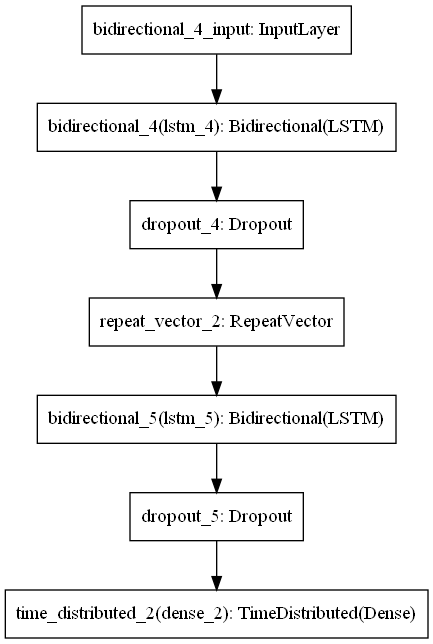

In [17]:
plot_model(model, to_file="version/{}/{}/figure.png".format(hyper_tuning_version, timestamp))

In [24]:
vocabulary = np.genfromtxt("static/vocabulary.csv", delimiter="\n", dtype=np.int64)
vocab_size = vocabulary.shape[0]
vocab_size

16293

In [25]:
param_list = dict()

param_list["PAST_HISTORY"] = 16
param_list["FUTURE_TARGET"] = 8
param_list["BATCH_SIZE"] = 32
param_list["VOCAB_SIZE"] = vocab_size

In [26]:
test_set = np.genfromtxt("data/{}_test_set.csv".format(dataset_name), delimiter="\n", dtype=np.int64)
test_set

array([ 172, 2711,  326, ...,    0,    6,    0], dtype=int64)

In [27]:
x_test = tf.data.Dataset.from_tensor_slices(test_set[:-param_list["FUTURE_TARGET"]]).window(param_list["PAST_HISTORY"], 1, 1, True)
x_test = x_test.flat_map(lambda x: x.batch(param_list["PAST_HISTORY"])) 
x_test = x_test.map(lambda x: tf.one_hot(x, param_list["VOCAB_SIZE"], axis=-1))
x_test = x_test.batch(param_list["BATCH_SIZE"])

In [28]:
y_test = tf.data.Dataset.from_tensor_slices(test_set[param_list["PAST_HISTORY"]:]).window(param_list["FUTURE_TARGET"], 1, 1, True)
y_test_slices = y_test.flat_map(lambda y: y.batch(param_list["FUTURE_TARGET"]))
y_test = y_test_slices.map(lambda y: tf.one_hot(y, param_list["VOCAB_SIZE"], axis=-1))
y_test = y_test.batch(param_list["BATCH_SIZE"])

In [29]:
test_data = tf.data.Dataset.zip((x_test, y_test))

In [30]:
loss, acc = model.evaluate(test_data)

1112/1112 [==============================] - 23s 21ms/step - loss: 1.9974 - accuracy: 0.5741


In [31]:
#y_pred = tf.argmax(model.predict(x_test), axis=-1).numpy()     # Unable to predict whole test_set at a time
y_pred = []
for x in x_test:
    y_pred.extend(tf.argmax(model.predict(x), axis=-1).numpy())
y_pred = np.array(y_pred)

In [32]:
y_true = np.array([yt for yt in y_test_slices.as_numpy_iterator()])

In [33]:
y_pred.shape, y_true.shape

((35556, 8), (35556, 8))

In [34]:
p, r, f = [], [], []
average_method = ["micro", "macro", "weighted"]

for method in average_method:
    precision = precision_score(np.ravel(y_true), np.ravel(y_pred), average=method)
    recall = recall_score(np.ravel(y_true), np.ravel(y_pred), average=method)
    f1 = f1_score(np.ravel(y_true), np.ravel(y_pred), average=method)
     
    p.append(precision)
    r.append(recall)
    f.append(f1)

In [35]:
report = pd.DataFrame(data=[p, r, f], columns=average_method, index=["precision", "recall", "f1"])
report

,micro,macro,weighted
precision,0.574094,0.517704,0.572331
recall,0.574094,0.495924,0.574094
f1,0.574094,0.486263,0.551933


In [36]:
accuracy = pd.DataFrame(data=[[loss, acc]], columns=["loss", "accuracy"])
accuracy

,loss,accuracy
0,1.997373,0.574094


In [37]:
report.to_csv("version/{}/{}/report.csv".format(hyper_tuning_version, timestamp))
accuracy.to_csv("version/{}/{}/accuracy.csv".format(hyper_tuning_version, timestamp), index=False)